In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Bandits2 import Bandits

In [2]:
def linucb_fairness42(self, ind=[], max_T=500, steps=25, seed=0, la=0.16, delta=0.12, noisef=0.1, repeats=20, 
                    eps=[0.25], beta=[1], q_p=[0.2], q_w=[1], wid=[1], plots=[0, 1]):
    np.random.seed(seed)
    ret_ = [[], []]
    noise = np.mean(self.rewards) * noisef
    func = {0: self.LinUCB, 1: self.LinUCB_eps_greedy, 2: self.LinUCB_cost, 3: self.LinUCB_queue, -3: self.LinUCB_queue, 4: self.LinUCB_fairbounds}
    func_name = {0: "Linear UCB", 1: "ε-greedy", 2: "Diversity Cost", 3: "Queue", -3:"Queue", 4: "Fair Bounds"}
    hp = {0: [""], 1: eps, 2: beta, 3: q_p, -3: q_w, 4: wid}
    labe = {0: "", 1: ", ε=", 2: ", β=", 3: ", q_p=", -3: ", q_w=", 4: ", w="}
    param = {0: [{"T": max_T, "steps":steps}],
             1: [{"T": max_T, "steps":steps, "eps":ep} for ep in eps],
             2: [{"T": max_T, "steps":steps, "beta":b} for b in beta],
             3: [{"T": max_T, "steps":steps, "q_p":qp, "q_w":q_w[0]} for qp in q_p],
             -3: [{"T": max_T, "steps":steps, "q_p":q_p[0], "q_w":qw} for qw in q_w],
             4: [{"T": max_T, "steps":steps, "wid":w} for w in wid]}

    x = [int(np.floor(i * max_T / steps)) for i in range(1, steps+1)]
    y = {}
    con = {}
    freq = {}
    err = {}
    errcon = {}
    FSI = {}

    for i in ind:
        y[i] = [np.zeros((repeats, steps)) for l in range(len(param[i]))]
        con[i] = [np.zeros((repeats, steps)) for l in range(len(param[i]))]
        freq[i] = [np.zeros((self.C, self.K)) for l in range(len(param[i]))]
        err[i] = []
        errcon[i] = []
        FSI[i] = []
            
    assert len(np.unique(x)) == steps

    # Run algorithms
    for i in ind:
        for l in range(len(param[i])):
            for r in range(repeats):
                y[i][l][r] += np.array(func[i](la, delta, noise, fixed=[True, r], **param[i][l])[4])
                con[i][l][r] += self.run_logs[self.run_count-1]["Consistency"]
                ca = self.chosen_arms()

                # Update chosen arms
                for c in range(self.C):
                    freq[i][l][c] += ca[0][c]
    
            err[i].append(np.std(y[i][l], axis=0, ddof=1) / np.sqrt(repeats))
            errcon[i].append(np.std(con[i][l], axis=0, ddof=1) / np.sqrt(repeats))
    
            self.df = freq[i][l]/repeats
            G = self.Gini_fairness()
            E = self.mix() + G
            FSI[i].append(E[0])
        

    for i in ind:
        for l in range(len(param[i])):
            ret_[0].append(np.sum(y[i][l], axis=0)/repeats)

    for i in ind:
        for l in range(len(param[i])):
            ret_[1].append(np.sum(con[i][l], axis=0)/repeats)

    return ret_, FSI

In [3]:
def lf_420(K, d, C, p, param, cutoff, alg=[0, 1, 2, 3], repe=10):
    func_name = {0: "Linear UCB", 1: "ε-greedy", 2: "Diversity Cost", 3: "Queue", -3:"Queue", 4: "Fair Bounds"}
    plotx = []
    ploty = []

    for seed in range(repe):
        A = Bandits(K=K, d=d, C=C, p=p, seed=seed)
        A.generate_context(max_T=100 * K * d**2 //9, repeats=10)
        print(f"seed={seed}")
        b = linucb_fairness42(A, ind=[1, 2, 3, 4], max_T=100 * K * d**2 //9, steps=1, seed=0, la=0.16, delta=0.12, noisef=0.1, repeats=10, 
                    eps=list(np.linspace(0, param[0], 21)), beta=list(np.linspace(0, param[1], 21)), 
                    q_p=list(np.linspace(0, param[2], 21)), q_w=[1], wid=list(np.linspace(0, param[3], 21)))
        
        plotx.append([b[1][i+1] for i in alg])
        ploty.append([b[0][1][i*21:(i+1)*21] for i in alg])
        

    # Plot 1
    plt.figure()
    plotx = np.array(plotx)
    ploty = np.array(ploty)
    for i in alg:
        x1 = np.mean(plotx[:, i, :], axis=0).flatten()
        xerr1 = np.std(plotx[:, i, :], axis=0, ddof=1).flatten() / np.sqrt(10)
        y1 = np.mean(ploty[:, i, :], axis=0).flatten()
        yerr1 = np.std(ploty[:, i, :], axis=0, ddof=1).flatten() / np.sqrt(10)
        plt.errorbar(x1, y1, xerr=xerr1, yerr=yerr1, label=func_name[i+1], linestyle='-', marker='o', markersize=2)

    plt.grid()
    plt.legend()
    plt.ylabel("Consistency")
    plt.xlabel("Fairness-Spread")
    plt.xlim(cutoff)
    plt.title("Relationship between consistency and fairness measure")
    plt.show()

### $d=10$

seed=0
seed=1
seed=2
seed=3
seed=4
seed=5
seed=6
seed=7
seed=8
seed=9


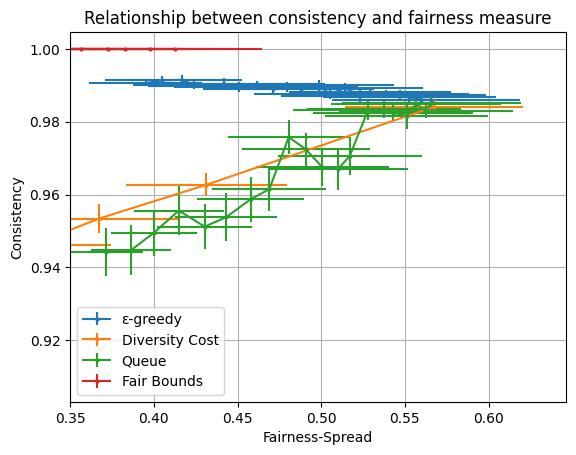

In [8]:
lf_420(5, 10, -1, 10, [2.5, 10, 0.6, 1], cutoff=0.35, repe=10)